In [1]:
import os
import mne
import numpy as np
import pickle
import glob

In [2]:
def save_data(data, output_file):
    with open(output_file, 'wb') as file:
        pickle.dump(data, file, protocol=4)

In [195]:
fif_file = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif"
output_dir = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy"
def read_and_crop_epochs(fif_file):
    epochs = mne.read_epochs(fif_file, preload=True)
    cropped_epochs = epochs.crop(tmin=0, tmax=1.0)
    return cropped_epochs

epochs = read_and_crop_epochs(fif_file)    

sorted_indices = np.argsort(epochs.events[:, 2])
epochs = epochs[sorted_indices]

Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

In [197]:

print(len(epochs.events))
epochs.events

27048


array([[ 8514835,        0,        1],
       [ 8091349,        0,        2],
       [48325382,        0,        3],
       ...,
       [45412120,        0,   999999],
       [ 8965011,        0,   999999],
       [28052042,        0,   999999]], dtype=int32)

In [198]:
import pandas as pd
csv_file_path = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/Metadata/Concept-specific/image_concept_index.csv'
image_concept_df = pd.read_csv(csv_file_path, header=None)
print(image_concept_df)


# Accessing a column by its name
# Display the first few rows to understand its structure
image_concept_df.shape[0]

          0
0         1
1         1
2         1
3         1
4         1
...     ...
26102  1854
26103  1854
26104  1854
26105  1854
26106  1854

[26107 rows x 1 columns]


26107

In [199]:
def filter_valid_epochs(epochs, exclude_event_id=999999):
    return epochs[epochs.events[:, 2] != exclude_event_id]

valid_epochs = filter_valid_epochs(epochs)
valid_epochs.info
valid_epochs.events.shape

(24648, 3)

In [200]:
def identify_zs_event_ids(epochs, num_repetitions=12):
    event_ids = epochs.events[:, 2]
    unique_event_ids, counts = np.unique(event_ids, return_counts=True)
    zs_event_ids = unique_event_ids[counts == num_repetitions]
    return zs_event_ids

zs_event_ids = identify_zs_event_ids(valid_epochs)
# Verify the zero-shot event IDs
print("Zero-shot Event IDs:", zs_event_ids)

len(zs_event_ids)

Zero-shot Event IDs: [  148   191   244   264   591   619   646   663   808   828   895   914
   944   960  1279  1481  1510  1556  1610  1640  1664  1719  1748  1794
  1858  1899  2159  2286  2312  2378  2393  2783  2839  3061  3099  3255
  3268  3435  3651  3739  3880  4030  4137  4205  4562  4603  4654  4851
  5161  5226  5360  5705  5777  6076  6098  6165  6265  6312  6404  6634
  6653  6704  6805  6924  7093  7260  7324  7464  7480  7499  7513  7539
  7557  7863  7892  7976  8173  8404  8696  8925  8954  9114  9142  9334
  9610 10005 10087 10166 10328 10351 10548 10921 10965 10993 11098 11123
 11199 11437 11450 11575 11609 11821 11917 12019 12033 12213 12374 12457
 12520 12605 12708 12877 12969 13105 13319 13356 13701 13786 13809 13946
 14083 14110 14247 14297 14514 14555 14572 14692 15053 15145 15223 15293
 15323 15586 15614 15718 15747 16101 16153 16307 16598 16641 17050 17253
 17517 17558 17873 18023 18049 18643 18738 19767 19929 19981 20142 20205
 20399 20528 20541 21365 21497

200

In [201]:
# Separate and process datasets
training_epochs = valid_epochs[~np.isin(valid_epochs.events[:, 2], zs_event_ids)]
# Verify the number of events in the training set
print("Number of events in the training set:", len(training_epochs.events))
print(len(training_epochs.events))

Number of events in the training set: 22248
22248


In [202]:
# Extract event IDs from the filtered training epochs
training_event_ids = np.unique(training_epochs.events[:, 2])

# Check for any overlap between zero-shot and training event IDs
overlap_ids = np.intersect1d(zs_event_ids, training_event_ids)

# Print the overlap, if any
print("Overlapping Event IDs:", overlap_ids)

Overlapping Event IDs: []


In [203]:
zs_test_epochs = valid_epochs[np.isin(valid_epochs.events[:, 2], zs_event_ids)]
zs_test_epochs.events
len(zs_test_epochs.events)
# zs_test_epochs.events

2400

In [204]:
print(len(training_epochs.events))
print(len(zs_test_epochs.events))

22248
2400


In [209]:
training_epochs.events[:, -1]
zs_test_epochs.events[:, -1]

array([    1,     2,     3, ..., 26104, 26105, 26106], dtype=int32)

In [210]:
import numpy as np


training_event_ids = training_epochs.events[:, -1]
test_event_ids = zs_test_epochs.events[:, -1]


counts = {test_id: np.sum(training_event_ids == test_id) for test_id in test_event_ids}
counts

{148: 0,
 191: 0,
 244: 0,
 264: 0,
 591: 0,
 619: 0,
 646: 0,
 663: 0,
 808: 0,
 828: 0,
 895: 0,
 914: 0,
 944: 0,
 960: 0,
 1279: 0,
 1481: 0,
 1510: 0,
 1556: 0,
 1610: 0,
 1640: 0,
 1664: 0,
 1719: 0,
 1748: 0,
 1794: 0,
 1858: 0,
 1899: 0,
 2159: 0,
 2286: 0,
 2312: 0,
 2378: 0,
 2393: 0,
 2783: 0,
 2839: 0,
 3061: 0,
 3099: 0,
 3255: 0,
 3268: 0,
 3435: 0,
 3651: 0,
 3739: 0,
 3880: 0,
 4030: 0,
 4137: 0,
 4205: 0,
 4562: 0,
 4603: 0,
 4654: 0,
 4851: 0,
 5161: 0,
 5226: 0,
 5360: 0,
 5705: 0,
 5777: 0,
 6076: 0,
 6098: 0,
 6165: 0,
 6265: 0,
 6312: 0,
 6404: 0,
 6634: 0,
 6653: 0,
 6704: 0,
 6805: 0,
 6924: 0,
 7093: 0,
 7260: 0,
 7324: 0,
 7464: 0,
 7480: 0,
 7499: 0,
 7513: 0,
 7539: 0,
 7557: 0,
 7863: 0,
 7892: 0,
 7976: 0,
 8173: 0,
 8404: 0,
 8696: 0,
 8925: 0,
 8954: 0,
 9114: 0,
 9142: 0,
 9334: 0,
 9610: 0,
 10005: 0,
 10087: 0,
 10166: 0,
 10328: 0,
 10351: 0,
 10548: 0,
 10921: 0,
 10965: 0,
 10993: 0,
 11098: 0,
 11123: 0,
 11199: 0,
 11437: 0,
 11450: 0,
 11575: 0,

In [211]:
# Assuming zs_event_ids is a numpy array or a list of event IDs
# Assuming image_concept_df is a pandas DataFrame with one column '1' representing image category indices

zs_event_to_category_map = {}

for i, event_id in enumerate(zs_event_ids):
    # Using the row index (i) to map to the image category index
    # Assuming the first event_id corresponds to the first row, second event_id to the second row, and so on
    image_category_index = image_concept_df.iloc[event_id-1, 0]  # Accessing the first (and only) column at row i
    zs_event_to_category_map[event_id] = image_category_index

# Print the mapping
print("Event ID to Image Category Index Mapping:")
for event_id, category_index in zs_event_to_category_map.items():
    print(f"Event ID {event_id}: Image Category Index {category_index}")

Event ID to Image Category Index Mapping:
Event ID 148: Image Category Index 10
Event ID 191: Image Category Index 13
Event ID 244: Image Category Index 17
Event ID 264: Image Category Index 18
Event ID 591: Image Category Index 42
Event ID 619: Image Category Index 44
Event ID 646: Image Category Index 46
Event ID 663: Image Category Index 47
Event ID 808: Image Category Index 55
Event ID 828: Image Category Index 56
Event ID 895: Image Category Index 60
Event ID 914: Image Category Index 61
Event ID 944: Image Category Index 63
Event ID 960: Image Category Index 64
Event ID 1279: Image Category Index 86
Event ID 1481: Image Category Index 98
Event ID 1510: Image Category Index 100
Event ID 1556: Image Category Index 103
Event ID 1610: Image Category Index 106
Event ID 1640: Image Category Index 108
Event ID 1664: Image Category Index 109
Event ID 1719: Image Category Index 112
Event ID 1748: Image Category Index 114
Event ID 1794: Image Category Index 117
Event ID 1858: Image Categor

In [212]:
# List to hold all the categories in the test set
test_set_categories = []

# Iterate over the event IDs in the test set
for event_id in zs_event_ids:
    if event_id in zs_event_to_category_map:
        # Get the category index from the mapping
        category_index = zs_event_to_category_map[event_id]
        test_set_categories.append(category_index)

# Print the list of categories in the test set
print("Categories in the test set:", test_set_categories)
len(test_set_categories)
# test_set_categories

Categories in the test set: [10, 13, 17, 18, 42, 44, 46, 47, 55, 56, 60, 61, 63, 64, 86, 98, 100, 103, 106, 108, 109, 112, 114, 117, 121, 124, 141, 149, 151, 155, 156, 183, 187, 202, 205, 216, 217, 230, 246, 253, 263, 274, 282, 287, 313, 316, 320, 335, 356, 361, 371, 396, 401, 422, 423, 427, 433, 436, 442, 458, 459, 462, 469, 478, 490, 502, 506, 514, 515, 516, 517, 519, 520, 541, 543, 549, 564, 580, 601, 618, 620, 631, 633, 648, 670, 698, 703, 708, 720, 721, 735, 762, 765, 767, 775, 776, 782, 799, 800, 809, 811, 826, 833, 840, 841, 853, 865, 870, 874, 880, 887, 899, 906, 916, 932, 934, 961, 967, 968, 978, 988, 990, 1000, 1003, 1018, 1021, 1022, 1030, 1057, 1064, 1070, 1075, 1077, 1094, 1096, 1104, 1106, 1130, 1134, 1146, 1166, 1169, 1199, 1213, 1231, 1234, 1254, 1264, 1266, 1309, 1316, 1392, 1403, 1407, 1419, 1424, 1438, 1447, 1448, 1510, 1520, 1535, 1542, 1555, 1563, 1567, 1572, 1583, 1584, 1590, 1603, 1607, 1614, 1618, 1619, 1630, 1641, 1642, 1644, 1649, 1655, 1664, 1673, 1682, 1707,

200

In [213]:
from collections import Counter

# Count the occurrences of each category ID in the training set
category_counts = Counter(test_set_categories)

# Print the counts of each category ID
print("Counts of each category ID in the training set:")
for category_id, count in category_counts.items():
    print(f"Category ID {category_id}: Count {count}")

Counts of each category ID in the training set:
Category ID 10: Count 1
Category ID 13: Count 1
Category ID 17: Count 1
Category ID 18: Count 1
Category ID 42: Count 1
Category ID 44: Count 1
Category ID 46: Count 1
Category ID 47: Count 1
Category ID 55: Count 1
Category ID 56: Count 1
Category ID 60: Count 1
Category ID 61: Count 1
Category ID 63: Count 1
Category ID 64: Count 1
Category ID 86: Count 1
Category ID 98: Count 1
Category ID 100: Count 1
Category ID 103: Count 1
Category ID 106: Count 1
Category ID 108: Count 1
Category ID 109: Count 1
Category ID 112: Count 1
Category ID 114: Count 1
Category ID 117: Count 1
Category ID 121: Count 1
Category ID 124: Count 1
Category ID 141: Count 1
Category ID 149: Count 1
Category ID 151: Count 1
Category ID 155: Count 1
Category ID 156: Count 1
Category ID 183: Count 1
Category ID 187: Count 1
Category ID 202: Count 1
Category ID 205: Count 1
Category ID 216: Count 1
Category ID 217: Count 1
Category ID 230: Count 1
Category ID 246: C

In [214]:
# Assuming zs_event_ids is a numpy array or a list of event IDs
# Assuming image_concept_df is a pandas DataFrame with one column '1' representing image category indices

event_to_category_map = {}

for i, event_id in enumerate(training_event_ids):
    # Using the row index (i) to map to the image category index
    # Assuming the first event_id corresponds to the first row, second event_id to the second row, and so on
    image_category_index = image_concept_df.iloc[event_id-1, 0]  # Accessing the first (and only) column at row i
    event_to_category_map[event_id] = image_category_index

# Print the mapping
print("Event ID to Image Category Index Mapping:")
for event_id, category_index in event_to_category_map.items():
    print(f"Event ID {event_id}: Image Category Index {category_index}")

Event ID to Image Category Index Mapping:
Event ID 1: Image Category Index 1
Event ID 2: Image Category Index 1
Event ID 3: Image Category Index 1
Event ID 4: Image Category Index 1
Event ID 5: Image Category Index 1
Event ID 6: Image Category Index 1
Event ID 7: Image Category Index 1
Event ID 8: Image Category Index 1
Event ID 9: Image Category Index 1
Event ID 10: Image Category Index 1
Event ID 11: Image Category Index 1
Event ID 12: Image Category Index 1
Event ID 15: Image Category Index 2
Event ID 16: Image Category Index 2
Event ID 17: Image Category Index 2
Event ID 18: Image Category Index 2
Event ID 19: Image Category Index 2
Event ID 20: Image Category Index 2
Event ID 21: Image Category Index 2
Event ID 22: Image Category Index 2
Event ID 23: Image Category Index 2
Event ID 24: Image Category Index 2
Event ID 25: Image Category Index 2
Event ID 26: Image Category Index 2
Event ID 29: Image Category Index 3
Event ID 30: Image Category Index 3
Event ID 31: Image Category Ind

In [215]:
# Assuming training_epochs is a variable that contains your training set epochs
# And it has an 'events' attribute similar to zs_test_epochs

# List to hold all the categories in the training set
train_set_categories = []

# Extract event IDs from the training set
training_event_ids = training_epochs.events[:, 2]

# Iterate over the event IDs in the training set
for event_id in training_event_ids:
    if event_id in event_to_category_map:
        # Get the category index from the mapping
        category_index = event_to_category_map[event_id]        
        train_set_categories.append(category_index)

# Print the list of categories in the training set
print("Categories in the training set:", train_set_categories)
print("Total number of category entries in the training set:", len(train_set_categories))

Categories in the training set: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,

In [216]:
from collections import Counter

# Count the occurrences of each category ID in the training set
category_counts = Counter(train_set_categories)

# Print the counts of each category ID
print("Counts of each category ID in the training set:")
for category_id, count in category_counts.items():
    print(f"Category ID {category_id}: Count {count}")

Counts of each category ID in the training set:
Category ID 1: Count 12
Category ID 2: Count 12
Category ID 3: Count 12
Category ID 4: Count 12
Category ID 5: Count 12
Category ID 6: Count 12
Category ID 7: Count 12
Category ID 8: Count 12
Category ID 9: Count 12
Category ID 10: Count 12
Category ID 11: Count 12
Category ID 12: Count 12
Category ID 13: Count 12
Category ID 14: Count 12
Category ID 15: Count 12
Category ID 16: Count 12
Category ID 17: Count 12
Category ID 18: Count 12
Category ID 19: Count 12
Category ID 20: Count 12
Category ID 21: Count 12
Category ID 22: Count 12
Category ID 23: Count 12
Category ID 24: Count 12
Category ID 25: Count 12
Category ID 26: Count 12
Category ID 27: Count 12
Category ID 28: Count 12
Category ID 29: Count 12
Category ID 30: Count 12
Category ID 31: Count 12
Category ID 32: Count 12
Category ID 33: Count 12
Category ID 34: Count 12
Category ID 35: Count 12
Category ID 36: Count 12
Category ID 37: Count 12
Category ID 38: Count 12
Category ID

In [217]:

counts = {test_id: np.sum(train_set_categories == test_id) for test_id in test_set_categories}
# Calculate the total number of elements in 'counts'
total_elements = sum(counts.values())

# Print the total number of elements
print("Total number of elements represented in 'counts':", total_elements)

counts

Total number of elements represented in 'counts': 2400


{10: 12,
 13: 12,
 17: 12,
 18: 12,
 42: 12,
 44: 12,
 46: 12,
 47: 12,
 55: 12,
 56: 12,
 60: 12,
 61: 12,
 63: 12,
 64: 12,
 86: 12,
 98: 12,
 100: 12,
 103: 12,
 106: 12,
 108: 12,
 109: 12,
 112: 12,
 114: 12,
 117: 12,
 121: 12,
 124: 12,
 141: 12,
 149: 12,
 151: 12,
 155: 12,
 156: 12,
 183: 12,
 187: 12,
 202: 12,
 205: 12,
 216: 12,
 217: 12,
 230: 12,
 246: 12,
 253: 12,
 263: 12,
 274: 12,
 282: 12,
 287: 12,
 313: 12,
 316: 12,
 320: 12,
 335: 12,
 356: 12,
 361: 12,
 371: 12,
 396: 12,
 401: 12,
 422: 12,
 423: 12,
 427: 12,
 433: 12,
 436: 12,
 442: 12,
 458: 12,
 459: 12,
 462: 12,
 469: 12,
 478: 12,
 490: 12,
 502: 12,
 506: 12,
 514: 12,
 515: 12,
 516: 12,
 517: 12,
 519: 12,
 520: 12,
 541: 12,
 543: 12,
 549: 12,
 564: 12,
 580: 12,
 601: 12,
 618: 12,
 620: 12,
 631: 12,
 633: 12,
 648: 12,
 670: 12,
 698: 12,
 703: 12,
 708: 12,
 720: 12,
 721: 12,
 735: 12,
 762: 12,
 765: 12,
 767: 12,
 775: 12,
 776: 12,
 782: 12,
 799: 12,
 800: 12,
 809: 12,
 811: 12,
 826: 

In [218]:
# Assuming train_set_categories and test_set_categories are lists or numpy arrays

# Create a new list with elements from train_set_categories that are not in test_set_categories
train_set_categories_filtered = [item for item in train_set_categories if item not in test_set_categories]

# train_set_categories_filtered now contains elements from train_set_categories excluding those in test_set_categories
print("Filtered train_set_categories:", train_set_categories_filtered)
len(train_set_categories_filtered)

Filtered train_set_categories: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 

19848

In [219]:
# Create a mask for epochs to keep in the training set
keep_epochs_mask = [category not in test_set_categories for category in train_set_categories]
keep_epochs_mask
# Apply the mask to filter out epochs from training_epochs
training_epochs_filtered = training_epochs[keep_epochs_mask]

# Confirm the filtering
print("Original training set size:", len(training_epochs))
print("Filtered training set size:", len(training_epochs_filtered))

Original training set size: 22248
Filtered training set size: 19848


In [220]:
def reshape_meg_data(epochs, num_concepts, num_imgs, repetitions):
    data = epochs.get_data()
    reshaped_data = data.reshape((num_concepts, num_imgs, repetitions, data.shape[1], data.shape[2]))
    return reshaped_data


training_data = reshape_meg_data(training_epochs_filtered, num_concepts=1654, num_imgs=12, repetitions=1)
training_data.shape

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


(1654, 12, 1, 271, 201)

In [221]:
zs_test_data = reshape_meg_data(zs_test_epochs, num_concepts=200, num_imgs=1, repetitions=12)
zs_test_data.shape

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


(200, 1, 12, 271, 201)

In [ ]:
# # Save data
# if not os.path.isdir(output_dir):
#     os.makedirs(output_dir)
# save_data({'meg_data': training_data, 'ch_names': training_epochs_filtered.ch_names, 'times': training_epochs_filtered.times},
#             os.path.join(output_dir, 'preprocessed_meg_training.pkl'))
# save_data({'meg_data': zs_test_data, 'ch_names': zs_test_epochs.ch_names, 'times': zs_test_epochs.times},
#             os.path.join(output_dir, 'preprocessed_meg_zs_test.pkl'))

KeyboardInterrupt: 

In [223]:
import numpy as np
import os

def process_and_save_meg_data(fif_file, output_dir):
    epochs = read_and_crop_epochs(fif_file)
    

    sorted_indices = np.argsort(epochs.events[:, 2])
    epochs = epochs[sorted_indices]

    valid_epochs = filter_valid_epochs(epochs)
    zs_event_ids = identify_zs_event_ids(valid_epochs)

    training_epochs = valid_epochs[~np.isin(valid_epochs.events[:, 2], zs_event_ids)]
    zs_test_epochs = valid_epochs[np.isin(valid_epochs.events[:, 2], zs_event_ids)]

    keep_epochs_mask = [category not in test_set_categories for category in train_set_categories]
    training_epochs_filtered = training_epochs[keep_epochs_mask]

    training_data = reshape_meg_data(training_epochs_filtered, num_concepts=1654, num_imgs=12, repetitions=1)
    zs_test_data = reshape_meg_data(zs_test_epochs, num_concepts=200, num_imgs=1, repetitions=12)

    # Save data
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    save_data({'meg_data': training_data, 'ch_names': training_epochs_filtered.ch_names, 'times': training_epochs_filtered.times},
              os.path.join(output_dir, 'preprocessed_meg_training.pkl'))
    save_data({'meg_data': zs_test_data, 'ch_names': zs_test_epochs.ch_names, 'times': zs_test_epochs.times},
              os.path.join(output_dir, 'preprocessed_meg_zs_test.pkl'))

# fif_file = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif"
# output_dir = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy"
# process_and_save_meg_data(fif_file, output_dir)

In [128]:
# def process_and_save_meg_data(fif_file, output_dir):
#     epochs = read_and_crop_epochs(fif_file)    
#     valid_epochs = filter_valid_epochs(epochs)    
#     zs_event_ids = identify_zs_event_ids(valid_epochs)
    
#     training_epochs = valid_epochs[~np.isin(valid_epochs.events[:, 2], zs_event_ids)]    
#     zs_test_epochs = valid_epochs[np.isin(valid_epochs.events[:, 2], zs_event_ids)]
    
#     keep_epochs_mask = [category not in test_set_categories for category in train_set_categories]    
#     training_epochs_filtered = training_epochs[keep_epochs_mask]


#     training_data = reshape_meg_data(training_epochs_filtered, num_concepts=1654, num_imgs=12, repetitions=1)
#     zs_test_data = reshape_meg_data(zs_test_epochs, num_concepts=200, num_imgs=1, repetitions=12)

#     # Save data
#     if not os.path.isdir(output_dir):
#         os.makedirs(output_dir)
#     save_data({'meg_data': training_data, 'ch_names': training_epochs_filtered.ch_names, 'times': training_epochs_filtered.times},
#                 os.path.join(output_dir, 'preprocessed_meg_training.pkl'))
#     save_data({'meg_data': zs_test_data, 'ch_names': zs_test_epochs.ch_names, 'times': zs_test_epochs.times},
#                 os.path.join(output_dir, 'preprocessed_meg_zs_test.pkl'))

# # fif_file = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif"
# # output_dir = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy"
# # process_and_save_meg_data(fif_file, output_dir)

Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


In [224]:
def process_directory(input_dir, output_dir):
    fif_files = glob.glob(os.path.join(input_dir, '**/*epo.fif'), recursive=True)
    for fif_file in fif_files:
        filename = os.path.basename(fif_file)
        subject_num = filename.split('_')[1].split('-')[0]
        subject_dir_name = f"sub-{int(subject_num[1:]):02d}"
        subject_output_dir = os.path.join(output_dir, subject_dir_name)
        process_and_save_meg_data(fif_file, subject_output_dir)

In [225]:
in_dir = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/"
output_dir = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy"
process_directory(in_dir, output_dir)

Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items acti

/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/tmp/ipykernel_3641612/3314576471.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


In [179]:
import os
import shutil
import csv
import pandas as pd
import mne
import numpy  as np
csv_img_file_path = "/home/ldy/Workspace/THINGS/osfstorage/THINGS/Metadata/Image-specific/image_paths.csv"
origin_img_dir = "/home/ldy/Workspace/THINGS/osfstorage/THINGS/Images/"
training_images_dir = "/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/training_images"
test_images_dir = "/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/test_images"

In [180]:
image_df = pd.read_csv(csv_img_file_path, header=None)
print(image_df)

                                      0
0      images/aardvark/aardvark_01b.jpg
1      images/aardvark/aardvark_02s.jpg
2      images/aardvark/aardvark_03s.jpg
3      images/aardvark/aardvark_04s.jpg
4      images/aardvark/aardvark_05s.jpg
...                                 ...
26102  images/zucchini/zucchini_09s.jpg
26103  images/zucchini/zucchini_10s.jpg
26104  images/zucchini/zucchini_11s.jpg
26105  images/zucchini/zucchini_12s.jpg
26106  images/zucchini/zucchini_13s.jpg

[26107 rows x 1 columns]


In [181]:
training_epochs_filtered.events

array([[    3425,        0,    24812],
       [    5406,        0,     8355],
       [    7267,        0,     9054],
       ...,
       [50512219,        0,    19070],
       [50513879,        0,     5680],
       [50515800,        0,     6138]], dtype=int32)

In [182]:
import pandas as pd
concept_csv_file_path = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/Metadata/Concept-specific/image_concept_index.csv'
image_concept_df = pd.read_csv(concept_csv_file_path, header=None)
print(image_concept_df)

          0
0         1
1         1
2         1
3         1
4         1
...     ...
26102  1854
26103  1854
26104  1854
26105  1854
26106  1854

[26107 rows x 1 columns]


In [189]:
len(training_epochs_filtered.events[:, -1])

19848

In [187]:
import pandas as pd
import os
import shutil

concept_csv_file_path = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/Metadata/Concept-specific/image_concept_index.csv'
image_concept_df = pd.read_csv(concept_csv_file_path, header=None)

for index, row in image_df.iterrows():
    source_image_path = row[0]
    event_id = index + 1


    category_index = image_concept_df.iloc[event_id - 1, 0]

    path_parts = source_image_path.split('/')

    if len(path_parts) > 2:

        formatted_index = str(category_index).zfill(5)
        path_parts[1] = f"{formatted_index}_{path_parts[1]}"

    image_path = '/'.join(path_parts)
    

    if event_id in training_epochs_filtered.events[:, -1]:
        target_dir = os.path.join(training_images_dir)
    elif event_id in zs_test_epochs.events[:, -1]:
        target_dir = os.path.join(test_images_dir)
    else:
        continue
    # print(image_path)

    src_file = os.path.join(origin_img_dir, source_image_path)
    dest_file = os.path.join(target_dir, image_path)
    # print(src_file)
    # print(target_dir)
    # print(dest_file)

    os.makedirs(os.path.dirname(dest_file), exist_ok=True)
    shutil.copy(src_file, dest_file)

In [157]:
# # Iterate over each row in the DataFrame
# for index, row in image_df.iterrows():
#     image_path = row[0]
#     event_id = index + 1  # Since DataFrame indexing starts at 0, add 1 to match event_id

#     # Check if event_id belongs to the training set or test set
#     if event_id in training_epochs_filtered.events[:, -1]:
#         target_dir = training_images_dir
#     elif event_id in zs_test_epochs.events[:, -1]:
#         target_dir = test_images_dir
#     else:
#         continue  # Skip this image if event_id is not in either set

#     # Construct the full path for the source and destination files
#     src_file = os.path.join(origin_img_dir, image_path)
#     dest_file = os.path.join(target_dir, image_path)

#     # Create the target directory (if it does not exist) and copy the file
#     os.makedirs(os.path.dirname(dest_file), exist_ok=True)
#     shutil.copy(src_file, dest_file)


In [191]:
import os

training_images_dir = "/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/training_images/images/"

def count_images(directory):
    total_dirs = 0
    total_images = 0


    for entry in os.listdir(directory):
        path = os.path.join(directory, entry)
        if os.path.isdir(path):
            total_dirs += 1

            total_images += len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])

    return total_dirs, total_images

num_dirs, num_images = count_images(training_images_dir)

print(f"There are {num_dirs} subdirectories in total")
print(f"All subdirectories together contain {num_images} images in total")


总共有 1654 个子目录
所有子目录加起来总共有 19848 张图片


In [134]:

import pickle

path = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy/sub-01/preprocessed_meg_training.pkl"


with open(path, 'rb') as file:
    data = pickle.load(file)



meg_data = data['meg_data']
ch_names = data['ch_names']
times = data['times']
meg_data.shape


(1654, 12, 1, 271, 201)

In [135]:
path = "/home/ldy/Workspace/THINGS_MEG/ds004212/derivatives/preprocessed_npy/sub-01/preprocessed_meg_zs_test.pkl"

with open(path, 'rb') as file:
    data = pickle.load(file)



meg_data = data['meg_data']
ch_names = data['ch_names']
times = data['times']
meg_data.shape

(200, 1, 12, 271, 201)

In [ ]:
print(np.std(meg_data))

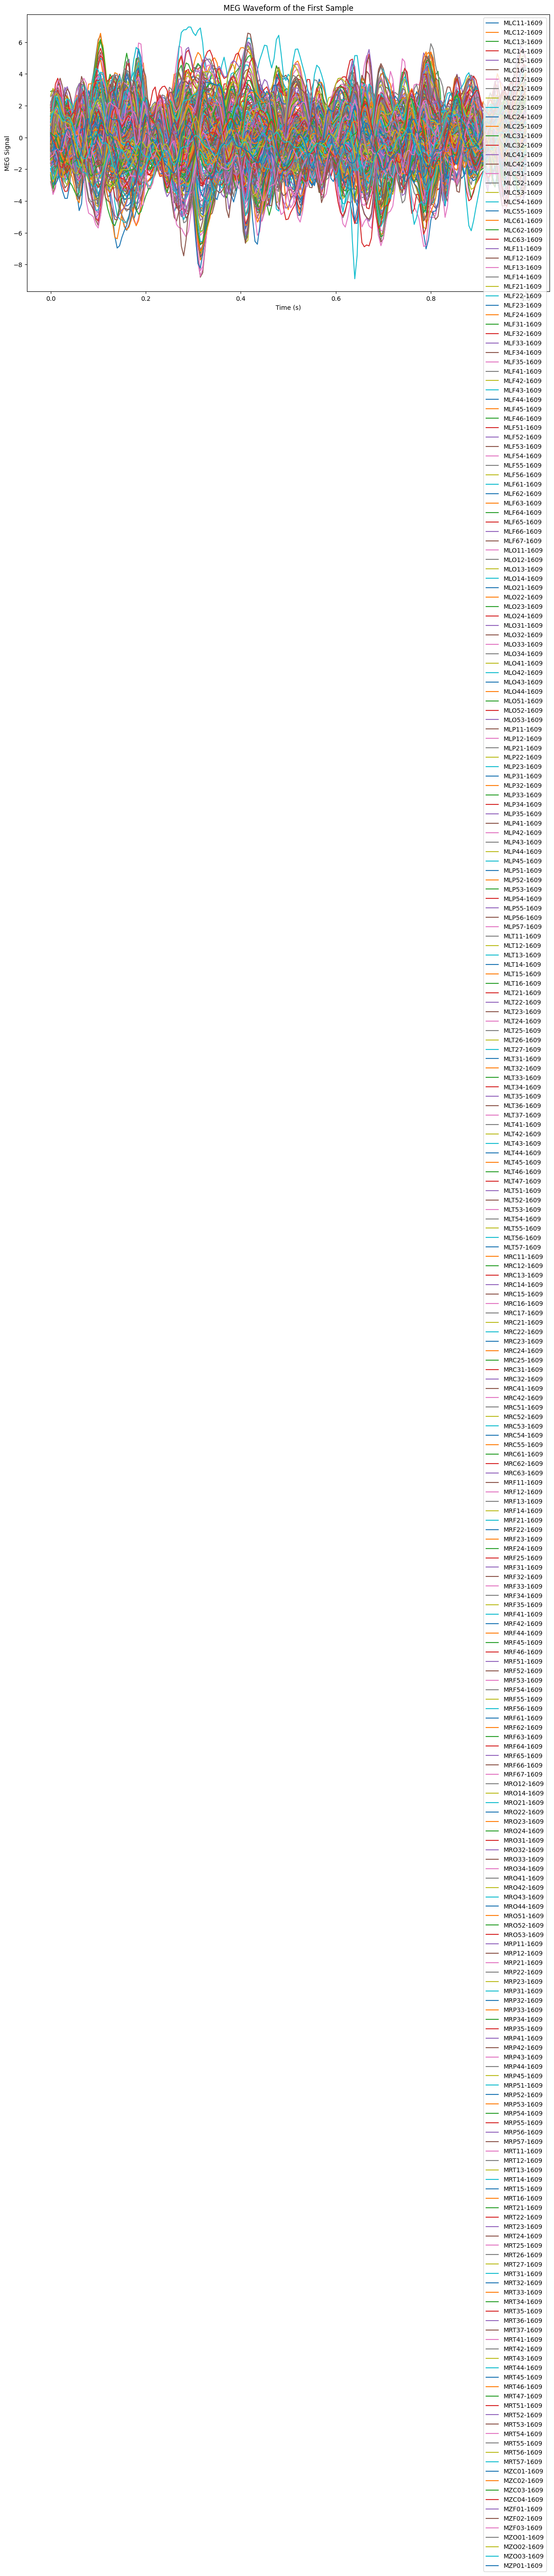

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming meg_data is of shape (samples, channels, time_points)
first_sample = meg_data[0, 0, 0, :, :]  # Select the first sample

# Plotting
plt.figure(figsize=(15, 8))  # Adjust the size as needed

# You may not want to plot all channels if there are many, so adjust this as needed
for i, ch_name in enumerate(ch_names):
    plt.plot(times, first_sample[i, :], label=ch_name)

plt.xlabel('Time (s)')  # Assuming 'times' is in seconds
plt.ylabel('MEG Signal')  # Adjust label as appropriate
plt.title('MEG Waveform of the First Sample')
plt.legend()  # Comment out if there are too many channels
plt.show()